In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sklearn as sklearn
from sklearn import decomposition,cluster
import re
import statsmodels.api as sm
import plotly.graph_objects as go
import geoplot as gplt
import geopandas as gpd

def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    gdf = gdf.reset_index()
    gdf = gdf.set_index('Pays_indic')
    return(gdf)

def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64))/np.log10(df_norm.astype(np.float64).max()))

def geo_plot (df,indic,annee,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    gplt.choropleth(gdf,
                hue = annee,
                cmap = couleur,
                #norm=colors.LogNorm(vmin=gdf[annee].min(),
                #                    vmax=gdf[annee].max()),
                legend=True,
                ax=ax)
    plt.show()

## Application de la méthode des k-means à la base obtenue

In [26]:
df1 = pd.read_csv("Complete_Data.csv")
df1 = df1.set_index('Pays_indic')
dic_code = refresh_dico('Country Code','Country Name',df1)

On crée ici une liste des codes de pays, et un dictionnaire avec le nom des variables afin de faciliter les manipulations

In [27]:
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

Afin d'étudier les sentiers de croissance et leurs dépendances énergétiques, nous avons retenu trois catégories de variables :

    - La valeur en 2000, qui nous permet d'estimer de manière absolue la niveau des variables. L'année 2000 a été retenu car nous notre base manque de donnée au début des années 80 et après 2010 pour certains pays.
    
    -Le taux de variation moyen, qui nous donne une bonne estimation de l'évolution de la variable sur notre jeu de donnée.
    
    -le coefficient de la régression ainsi que son R² pour les variables qui nous ont parues pertinentes. On a décidé de prendre ces indicateurs pour mesurer la dépendance entre les variables et la significativité de cette dépendance.

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation. Pour ça on définit les fonctions suivantes :

La fonction regress nous permet d'obtenir le coeffiecient et le R² de la régression.

In [16]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return


Cette fonction permet de créer un dataframe contenant les valeurs de la régression pour tous les pays.

In [20]:
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code, regresseur, regresse)
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df

get_2000 crée une dataframe à partir des valeurs en 2000 de la variable d'entrée pour chaque pays.

In [29]:
def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

Cette fonction nous permet d'obtenir le taux de variation moyen.

In [22]:
def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

Ici nous réalisons la création de la base des indicateurs par aggrégation.

In [30]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']),
            get_coeff(dic['pib_hab'], dic['nrj_hab'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)
data.shape

<ipython-input-22-99e7bd4fb978>:10: RuntimeWarning: divide by zero encountered in double_scalars
  variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
<ipython-input-22-99e7bd4fb978>:10: RuntimeWarning: invalid value encountered in double_scalars
  variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100


(168, 16)

Après plusieurs essais, nous avons automatisé l'application de la méthode des K-means à un dataframe ne contenant pas de NaN.

Cette fonction normalise la base, applique la méthode des K-means, puis réalise une ACP sur la base afin d'obtenir une représentation en deux dimensions.
Elle peut optionnellement tracer le graphe de l'inertie du clustering en fonction du nombre de cluster, elle peut également représenter la part de la variance expliquée pour chaque vecteur propre de l'ACP.

In [23]:
def get_cluster_ACP(n_k_means, data, graph_ACP=False,to_normalize=True,graph_k_means=False,seed=False):
    #normalisation
    if to_normalize == True :
        data_norm = pd.DataFrame()
        for i in data.columns :
            data_norm[i] = preprocessing.scale(data[i])
            data_norm.index = data.index
    else : 
        data_norm=data
        
    #On crée le graphe du coude des clusters
    if graph_k_means==True:
        iner = []
        for k in range(2,10):
            result=data_norm.copy()
            centroid, appartenance, inertie = sklearn.cluster.k_means(data_norm, k)
            iner.append(inertie)
        plt.plot(np.linspace(2,9,num=8),iner)
        plt.title("Evolution de l'inertie en fonction du nombre de cluster")
        plt.show() 
    
    
    #graph ACP
    if graph_ACP==True:
        
        PCA = sklearn.decomposition.PCA(10)
        PCA.fit(data_norm)

        res = PCA.explained_variance_ratio_

        t=np.linspace(1,10,num=10)
        plt.plot(t,PCA.explained_variance_ratio_*100)
        plt.title("Part de la variance expliquée sur chaque axe de l'ACP")
        plt.show()

    #on enregistre dans la base les centroïdes
    result=data_norm.copy()
    if seed != False:
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means,random_state=seed)
    else :
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means)
    for i in range(0,n_k_means):
        result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    
     
        
    #Application de l'ACP
    PCA = sklearn.decomposition.PCA(2)
    PCA.fit(data_norm)
    data_ds_acp = PCA.transform(data_norm)
    result_ACP = pd.DataFrame(data_ds_acp)
    
    #Enregistrement des données de l'ACP
    data_norm.loc['axis_1']=PCA.components_[0]
    data_norm.loc['axis_2']=PCA.components_[1]
    PCA_axis=data_norm.loc[['axis_1','axis_2']]
    
    #représentation graphique des clusters dans l'ACP
    result_ACP.index = result.index[:-n_k_means]
    result_ACP['Cluster'] = result['Cluster'][:-n_k_means]
    
    f = go.FigureWidget([go.Scatter(x=list(result_ACP[0]), 
                                y=list(result_ACP[1]), 
                                text=result_ACP.index,
                                mode='markers',
                                hoverinfo='text'
                                )])

    scatter = f.data[0]
    colormap = np.array(['black','red','royalblue','forestgreen','gold','silver','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick'])

    
    
    scatter.marker.color = colormap[result_ACP['Cluster'].astype(int).to_numpy()]
    scatter.marker.size = [10] * len(result_ACP.index)
    f.layout.hovermode = 'closest'
    
    #plt.title("Représentation des clusters dans L'ACP")
    f.show()
    
    dic_cluster={}
    for i in range (n_k_means):
        dic_cluster['Cluster'+str(i)]=list(result.where(result['Cluster'] == i).dropna().index[:-1])
        dic_cluster['Cluster'+str(i)].append(colormap[i])

        
    return result,dic_cluster,PCA_axis

A notre première tentative, nous avons appliqué cette méthode sur notre base où avons supprimé tous les pays dont il manquait un indicateur

In [31]:
data_1=data.dropna(axis=0)

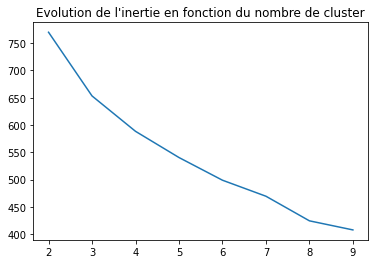

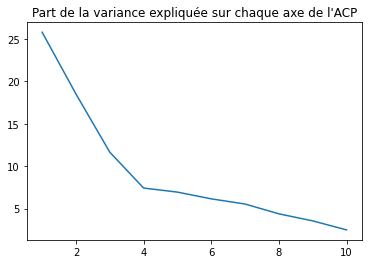

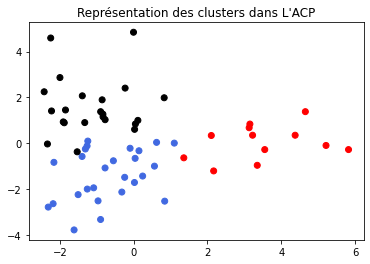

In [250]:
A,dic,axis=get_cluster_ACP(3,data_1,graph_ACP=True,graph_k_means=True,seed=1)


Dans un souci de visualisation, nous avons choisi de nous limiter au deux premiers axes de l'ACP, qui expliquent environ 45 % de la variance de notre jeu de donnée. On peut afficher axis pour les interpréter

In [251]:
axis

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)
axis_1,-0.083922,-0.113444,-0.242245,-0.180743,0.068738,-0.233689,0.432991,-0.310303,-0.036326,0.226164,0.372706,0.418256,-0.315826,0.005593,0.011666,-0.281782
axis_2,0.417687,-0.243149,-0.188613,0.329397,0.033347,0.410420,0.111488,-0.292115,0.183203,0.008673,0.069575,0.163092,0.077947,0.370132,0.193883,0.330574


Les pays à droite dans ce plan sont, grossièrement, les pays avec dont les indicateurs économiques sont significativement au-dessus de la moyenne en 2000, et dont le rythme de croissance de nos indicateurs est plutôt inférieur à la moyenne. Les pays plutôt en haut, quand à eux, sont ceux dont la croissance a été très au-dessus de la moyenne, ce qui passe par une forte consommation d'énergie. Certte dernière est pour eux assez corrélée avec l'augmentation de la production, d'après les coefficients de régression et les R² associés.

In [117]:
A.tail(3)

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,0.662221,-0.369528,-0.068925,0.732833,-0.149695,0.893346,-0.302165,-0.140460,0.091702,-0.338126,-0.220337,-0.303177,0.483463,0.831323,0.209392,0.866244,0.0
Centroid 1,-0.016431,-0.459584,-0.828894,-0.564649,0.486405,-0.834137,1.533741,-0.825042,-0.332440,0.804375,1.244375,1.627530,-1.212338,0.096832,-0.116746,-1.004639,1.0
Centroid 2,-0.552758,0.524794,0.440887,-0.359482,-0.097830,-0.370922,-0.452203,0.499640,0.075840,-0.085144,-0.387888,-0.494633,0.150457,-0.748119,-0.123295,-0.269297,2.0


Après de multiples essais, nous en sommes arrivés à la conclusion que les meilleurs clusters stables sont ceux ci-dessus. En effet, nous avons remarqué que lorsque le nombre de cluster augmentait, les clusters étaient plus précis mais ne se retrouvaient pas nécessairement d'une fois sur l'autre. Nous avons donc choisi de nous concentrer sur les clusters suffisamment reconnaissables par l'algorythme pour rester stable, gage de significativité du cluster.

On retrouve très clairement trois catégories de pays :

-Les pays de l'OCDE, en rouge, associé au Centroïde 1, caractérisés par une croissance du PIB faible, une tendance à la baisse des secteurs industriels et agricoles, une taux de variation de la production énergétique étonnamment bas, et des valeurs en 2000 plus importantes que la moyenne, et une décorrélation du PIB aux émissions de GES et à la production énergétique.

-Les pays les moins développés, en bleu, associé au Centroïde 2, qui ont pour caractéristiques communes des indicateurs de faible valeur en ce qui concerne le PIB, l'énergie, l'émission de GES, la part d'énergie renouvelable et nucléaire, et une part importante de l'agriculture et de l'industrie dans le PIB. On retrouve également pour ces pays-là une faible corrélation du PIB à la croissance énergétique et aux émission de GES.

-Les pays en cours de développement, en noir, associé au Centroïde 0. Ces derniers se distinguent par une forte croissance du PIB, des émissions de GES et du secteur énergétique, bien que leurs valeurs nominales soient inférieures à celles de l'OCDE. Pour ce cluster, le PIB est corrélé de manière significative au émissions de GES et à la croissance énergétique.

### Suppression de certains indicateurs pour augmenter le jeu de donnée, et clustering sur cette nouvelle base

 Dans le but de rendre notre modèle plus pertinent par le biais d'un échantillon plus représentatif, nous avons choisi de faire entrer de nouveaux pays en éliminant certains indicateurs pour lesquels nous avions essentiellement des données sur les pays riches.

In [119]:
data_2=data.drop(['Average Growth Rate_Alternative and nuclear energy (% of total energy use)','Average Growth Rate_Energy use (kg of oil equivalent per capita)',
                '2000_Energy use (kg of oil equivalent per capita)','2000_Alternative and nuclear energy (% of total energy use)',
                'Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                'R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)'],axis=1)


In [120]:
data_2=data_2.dropna(axis=0)
data_2.shape

(108, 10)

Grâce à cette modification de la conception de notre base, nous l'avons étendu à 108 pays, ce qui est plus pertinent pour faire du clustering. C'est ce que nous faisons maintenant

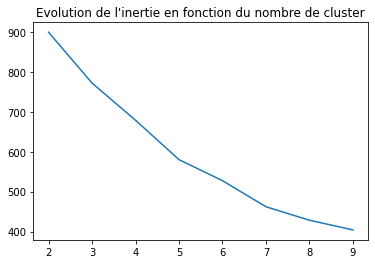

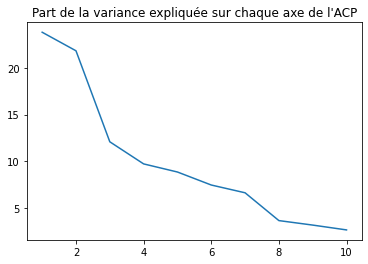

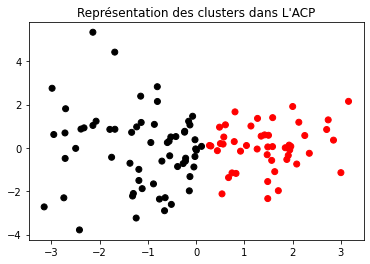

In [248]:
A,dic,axis=get_cluster_ACP(2,data_2,graph_ACP=True,graph_k_means=True)

Cette fois-ci, on voit clairement un "coude" dans le graphe de l'ACP, et on voit que les deux premiers axes permettent de rerésenter près de 50% de la variance totale, ce qui nous indique que notre représentation graphique est de qualité très correcte. En revanche, il est toujours aussi difficile de déterminer un nombre de cluster pertinent en se fondant sur l'inertie intraclasse. Comme l'analyse des axes n'apporte pas grand chose de plus que celle des clusters, nous ne l'effectuons plus à partir de maintenant.

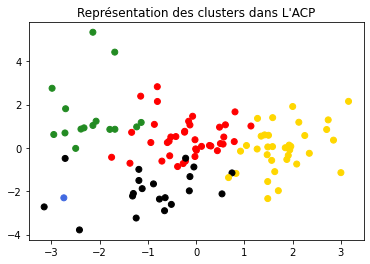

In [419]:
A,dic,axis=get_cluster_ACP(5,data_2, seed = 2)

In [420]:
A.tail()

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Cluster
Centroid 0,1.068014,-0.445809,0.170536,1.129572,-0.284261,-0.316524,0.138996,-0.369423,0.070083,1.559649,0.0
Centroid 1,-0.111847,-0.222676,-0.340420,-0.312992,-0.290950,-0.442192,0.404130,0.056935,-0.078867,-0.486499,1.0
Centroid 2,0.884699,-0.794461,0.595429,0.272024,1.167447,-1.235619,1.659612,-0.816174,9.864895,0.783132,2.0
Centroid 3,-0.228290,-0.100091,-0.609938,-0.539032,2.282571,-1.102016,0.128125,1.230458,-0.394336,0.294405,3.0
Centroid 4,-0.428543,0.578638,0.531731,-0.084832,-0.548962,1.202930,-0.638775,-0.365169,-0.069252,-0.526624,4.0


Si l'on garde 5 clusters, on arrive à identifier un motif qui se répète assez souvent. Il s'agit de celui inidqué ci-dessus, avec une seed égale à 5. 

    -Le cluster 0, en noir, correspond aux pays qui se sont beaucoup développé sur la période, notamment à l'aide d'un accroissement de l'émission de GES assez marque, leur PIB y étant significativement dépendant.
    -Le cluster un correspond à des pays de niveau de développement intermédiaire, dont la croissance de l'ensemble des indicateurs était inféreure à la moyenne. Il s'agit de pays dont le secteur agricole, contrairement au secteur industriel, était assez peu développé en 2000.
    -Le centroïde deux ne concerne que Puerto Rico, qui est une valeur assez singulière dans cette base. Il s'agit d'une valeur isolée, et sans l'isoler dans un cluster on rend le reste du modèle instable en déplaçant l'un des centroïdes vers un point non pertinent. Ainsi, si l'on ne garde que quatre clusters, leur structure est très instable. Puertor Rico a notamment une valeur presque aberrante en ce qui concerne le coefficient de régression du PIB sur l'émission de GES.
    -Le cluster 3 regroupe les pays qui polluaient beaucoup en 2000, et qui avaient un PIB très supérieur à la moyenne. Avec une croissance faible de l'industrie et un secteur industriel peu important et stagnant, il s'agit peu ou prou des pays industriels développés occidentaux.
    - Le dernier cluster regroupe des pays peu développés : ils sont fortement agricole, leur croissance est faible, et leur agriculture (et dans une moindre mesure leur industrie) représentent une part plus importante de leur PIB que dans les autres pays. 
    
Cette analyse à cinq clusters reste assez peu stable, mais elle permet de raffiner un peu l'analyse contrairement aux analyses avec moins de clusters. Celle en deux cluster oppose les pays développés (caricaturalement les pays occidentaux) aux pays en cours de développement. Et celle à trois clusters conserve un cluster pays développé (très stable quelque soit le nombre de clusters) et divise le cluster des pays moins développés entre ceux qui ont eu une forte croissance et ceux qui restent encore peu avanccés. On met les graphiques ci-dessous :

### On refait une analyse enconservant les variables sur l'énergie, mais en supprimant celles sur les secteurs d'activité

On a réussi à obtenir des résultats sur un échantillon plus grand, mais en supprimant certaines variables qui nous intéressaient, puisqu'eles portaient sur l'énergie. On cherche à voir si on peut retrouver ces résultats en conservant ces données, mais en supprimant celles portant sur les secteurs d'activité afin d'avoir un échantilllon plus important.

In [302]:
data_set_3=data.drop(['Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)',
                  'Average Growth Rate_Industry (including construction), value added (% of GDP)',
                  '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                  '2000_Industry (including construction), value added (% of GDP)'],axis=1)
data_set_3=data_set_3.dropna()
data_set_3.shape

(82, 12)

On a cette fois-ci un nombre de pays supérieur à notre base initiale, mais quand même inférieur à la base précédemment créée.

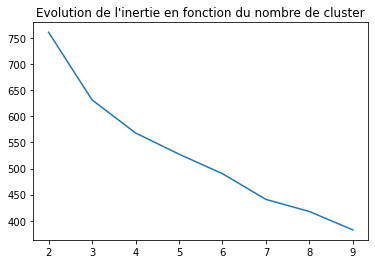

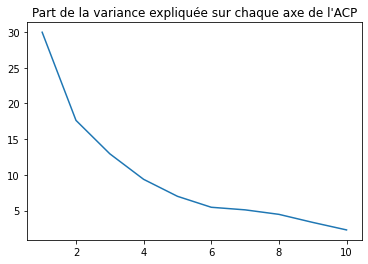

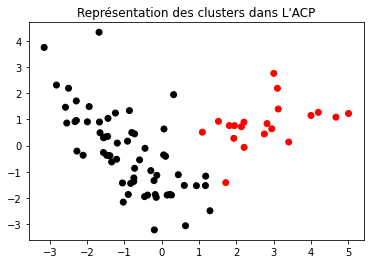

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,-0.027435,0.160944,-0.152678,0.198076,-0.426557,-0.291768,-0.340112,-0.459276,0.343863,-0.055951,0.109952,0.251935,0.0
Centroid 1,0.085049,-0.498926,0.473303,-0.614035,1.322327,0.904479,1.054348,1.423755,-1.065977,0.173447,-0.340851,-0.780998,1.0


In [305]:
A,dic,axis=get_cluster_ACP(2,data_set_3,graph_k_means=True,graph_ACP=True)
A.tail(2)

En ce qui concerne l'ACP, notre premier axe permet d'expliquer une grande part de la variance, et le deuxième apporte une contribution honorable. Notre représentation graphique devrait donc avoir du sens.
En revanche, il est toujours difficile de trouver un bon nombre de clusters en se basant sur l'inertie intraclasse.

On retrouve deux clusters la séparation entre pays riches et polluants d'une part, et les pays en cours de développement d'auttre part. Un des facteurs de séparation est toutefois l'élasticité énergétique du PIB. On voit ici que le centroïde correspondant au cluster des pays développés à des coefficients assez négatifs en ce qui concerne les coefficients des régressions, ainsi que le R² de la seconde régression. On voit donc que la production des pays développés est moins corrélée que celle des autres pays aux énergies utilisées, ainsi qu'à la quantité de GES émise. On pourrait expiquer cela par un niveau de développement plus avancé et donc à la fois une économie déjà assez industrialisée et surtout une part d'énergie alternative significativement au-dessus de la moyenne.

Ce dernier résultat est donc assez solide, puisqu'on le retrouve avec toutes nos bases jusqu'à présent. On va chercher à voir, avec plus de clusters, s'il est possible de raffiner cette analyse au niveau des pays en développement.

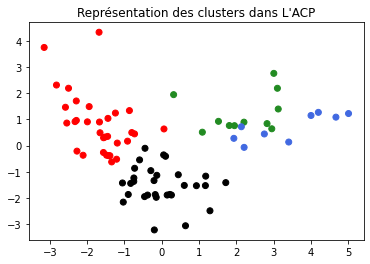

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
ZMB,-1.333725,-0.500974,-0.890624,-1.101673,-0.725765,2.215465,0.008550,-0.666205,0.110394,-1.252929,-0.719448,-1.481824,0.0
Centroid 0,-0.480735,-0.459852,-0.153801,-0.564275,-0.548255,-0.177313,-0.319889,-0.523228,0.105756,-0.736585,-0.076958,-0.533457,0.0
Centroid 1,0.398592,0.713043,-0.094837,0.884026,-0.408309,-0.410020,-0.333386,-0.424642,0.496617,0.509664,0.227780,0.926716,1.0
Centroid 2,0.227867,-0.634011,1.093589,-1.049924,1.521486,0.583289,0.954767,1.218837,-1.453690,0.672874,-1.846975,-1.150736,2.0
Centroid 3,-0.034882,-0.301428,-0.199407,-0.173752,1.438197,1.199132,1.061102,1.665075,-0.543748,-0.024324,1.058412,-0.299506,3.0


In [382]:
A,dic,axis=get_cluster_ACP(4,data_set_3, seed = 2)
A.tail()

In [383]:
print(dic)

{'Cluster0': ['AGO', 'ALB', 'ARG', 'BGR', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CUB', 'ETH', 'GAB', 'GHA', 'HND', 'HTI', 'ITA', 'JAM', 'KEN', 'MEX', 'NGA', 'NIC', 'PER', 'PHL', 'POL', 'PRY', 'ROU', 'SDN', 'TGO', 'VEN', 'ZMB', 'black'], 'Cluster1': ['AUT', 'BGD', 'BOL', 'BRA', 'BWA', 'CHL', 'CHN', 'CRI', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'GRC', 'GTM', 'IDN', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'NPL', 'PAK', 'PAN', 'PRT', 'SLV', 'THA', 'TUN', 'TUR', 'TZA', 'URY', 'VNM', 'red'], 'Cluster2': ['CHE', 'CZE', 'DEU', 'DNK', 'GBR', 'LUX', 'SVK', 'SWE', 'USA', 'royalblue'], 'Cluster3': ['AUS', 'BEL', 'CAN', 'FIN', 'FRA', 'IRL', 'ISL', 'JPN', 'NLD', 'NOR', 'NZL', 'forestgreen']}


Avec trois clusters, on a tendance à retrouver la même partition que dans notre modèle précédent.Les pays développés restent dans un même cluster. Les pays qui ont eu un rattrappage dans le développement qui est passé par une forte utilisation d'énergie et une forte émission de GES forment un second cluster, et les pays dont le développement est moins marqué forment un troisième cluster.

En revanche, la structure à qutre cluster que l'on retrouve avec la seed 2 est assez récurrente, et permet de faire une distinction supplémentaire parmi les pays développés au prix d'une plus forte instabilité de la séparation entre les deux clusters des pays en développement. 

Le cluster 2 est un cluster où les pays ont une évolution moins importante de l'utilisation de l'énergie que les autres pays développés. L'évolution de leurs émissions est en moyenne inférieur aussi, et au contraire il s'agit de pays qui ont beaucoup développé leur utilisation d'énergies alternatives sur la période même si en 2000 elle restait plus faible. Si l'on regarde les coefficients de nos régressions, il s'git de pays dont la production est beaucoup moins dépendante de la consommation d'énergie que les autres. C'est la premùière fois que l'on arrive à obtenir ces résultats, mais ils ne ssont pas totalement stable. De plus, on peut s'étonner de retrouver des pays comme l'Allemagne ou les USA dans ce cluster des pays "modèles" en terme d'élasticité énergétique de la croissance.

## On enlève les valeurs en 2000 pour n'avoir que des évolutions.

Pour se concentrer davantage sur ces sentiers de croissance, on décide de ne plus conserver les valeurs de nos variables en 2000. On espère voir davantage les clusters se concentrer sur les évolutions, et peut-être ne plus voir systématiquement apparaitre un cluster de pays riches. En revanche, comme on conserve tous nos indicateurs pour ce faire, on se retrouve sur une base avec seulement les 60 pays initiaux.

In [384]:
data_set_4=data.drop(['2000_GDP (current US$) par Tete',
                      '2000_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                      '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                      '2000_Industry (including construction), value added (% of GDP)',
                      '2000_Alternative and nuclear energy (% of total energy use)',
                      '2000_Energy use (kg of oil equivalent per capita)'],axis=1)
data_set_4=data_set_4.dropna()
data_set_4.shape

(60, 10)

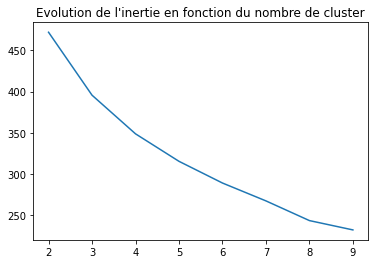

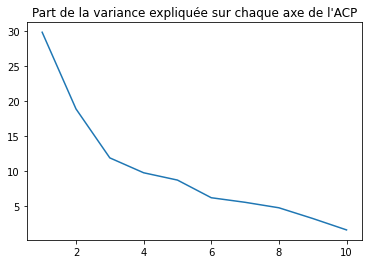

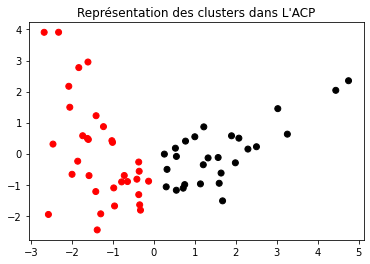

{'Cluster0': ['AUT', 'BGD', 'BOL', 'BRA', 'BWA', 'CHL', 'CHN', 'CRI', 'DOM', 'ECU', 'EGY', 'GTM', 'IDN', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'NPL', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'URY', 'VNM', 'black'], 'Cluster1': ['ARG', 'AUS', 'BGR', 'CHE', 'CIV', 'CMR', 'COG', 'COL', 'CUB', 'DNK', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GHA', 'HND', 'HTI', 'ITA', 'KEN', 'MEX', 'NGA', 'NLD', 'NOR', 'NZL', 'PHL', 'PRY', 'ROU', 'SDN', 'SWE', 'TGO', 'VEN', 'ZMB', 'red']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,0.563445,-0.236609,-0.014697,0.618222,-0.010219,0.805386,0.437434,0.533207,0.167631,0.836875,0.0
Centroid 1,-0.461000,0.193589,0.012025,-0.505818,0.008361,-0.658952,-0.357900,-0.436260,-0.137152,-0.684716,1.0


In [388]:
A,dic,axis=get_cluster_ACP(2,data_set_4,graph_ACP=True,graph_k_means=True)
print(dic)
A.loc[['Centroid 0', 'Centroid 1']]

La représentation dans le plan de l'ACP semble une nouvelle fois relativement fiable au vu de la varaince expliquée par les deux premiers axes (surtout par le premier). 

Il est toujours aussi difficile en revanche de trouver un nombre de cluster optimal par cette méthode de l'inertie intraclasse.

Cette fois-ci, lorsque l'on partitionne nos données en deux clusters, la distinction ne se fait plus selon le niveau des variables en 2000. Il s'agit au contraire de séparer d'un côté les pays qui ont eu une forte croissance, basée sur l'augmentation de l'utilisation de l'énergie par tête et des émission de GES. On retrouve ainsi des coefficients relativement importants et significatifs en ce qui concerne la régression linéaire du PIB sur ces dex indicateurs. En revanche, leur industrie et leur développement des énergies alternatives ne sont que proches de la moyenne, et le développement de l'agriculture un peu en-dessous. Le second cluster représente alors les pays qui ont une trajectoire exactement inverse.

On regarde si on peut raffiner un peu plus.

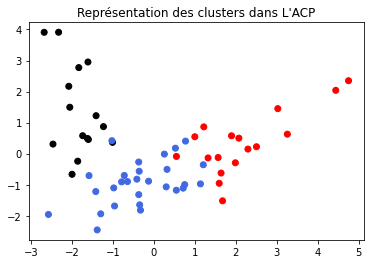

{'Cluster0': ['BGR', 'CHE', 'CMR', 'COL', 'CUB', 'DNK', 'FRA', 'GBR', 'GHA', 'PHL', 'PRY', 'ROU', 'SDN', 'SWE', 'ZMB', 'black'], 'Cluster1': ['AUT', 'BWA', 'CHL', 'CHN', 'DOM', 'EGY', 'IND', 'KOR', 'LKA', 'MAR', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'VNM', 'red'], 'Cluster2': ['ARG', 'AUS', 'BGD', 'BOL', 'BRA', 'CIV', 'COG', 'CRI', 'ECU', 'ETH', 'FIN', 'GAB', 'GTM', 'HND', 'HTI', 'IDN', 'ITA', 'KEN', 'MEX', 'MYS', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'TGO', 'URY', 'VEN', 'royalblue']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,-0.350320,-0.481203,-0.003116,-0.503823,0.398815,-1.062503,-0.656798,-0.075712,-1.078421,-1.407172,0.0
Centroid 1,0.760603,-0.396542,0.033453,0.987399,-0.041275,0.899536,0.639208,1.238807,0.161698,0.805072,1.0
Centroid 2,-0.274123,0.498545,-0.018642,-0.329587,-0.188591,0.023051,-0.036235,-0.711573,0.479552,0.265049,2.0


In [575]:
A,dic,axis=get_cluster_ACP(3,data_set_4, seed = 1)
print(dic)
A.tail(3)

La structure à trois clusters est relativement stable aussi, on identifie trois groupes de pays relativement satbles, avec seulement quatre ou cinq pays qui changent de groupes d'une fois sur l'autre. Ici, avec la graine 1, cela donne :

Le cluster 0 comprend les pays qui ont une corissance économique relativement lente, avec notamment une agriculture peu dynamique. Il s'agit surtout d'un groupe de pays où 'utilisation d'énergie, et dans une moindre mesure les émissions de GES, croit moins vite que dans les autres pays. On y voit que le PIB ne dépend que très peu de l'utilisation d'énergie ou de la production de GES. Il s'agit donc de pays ayant pour la plupart atteit un niveau de développement assez élevé (ou pour les autres qui stagnent, comme le Ghana), et qui semblent plafonner. Toutefois, cela se traduit par une plus faible émission de GES, ce qui est une bonne nouvelle. Certains points restent bien isolés quand on augmente le nombre de clusters (notamment la Suède, la Suisse, la Grande Bretagne, le Danemark, la Roumanie, la Bulgarie et la Colombie).

Le cluster 1 est assez semblable au cluster des pays au développement économique fort et polluant que l'on retrouvait à deux clusters. On y retrouve des pays qui correspondent bien à cette définition, comme la Chine, la Corée, la Turquie ou l'Autriche. 

Le cluster 2 regroupe des pays au développement plus incertain. La croissance économique est inférieure à la moyenne, et la seule évolution significativement au-dessus de la moyenne est celle de l'agriculture. Il s'agit en fait d'un cluster très dur à interpréter, qui est souvent divisé en deux ou trois lorsque le nombre de clusters augmente. On y retrouve des pays ausssi différent apparemment que la Nouvelle Zélande, l'Italie, l'Éthiopie et l'Uruguay. 



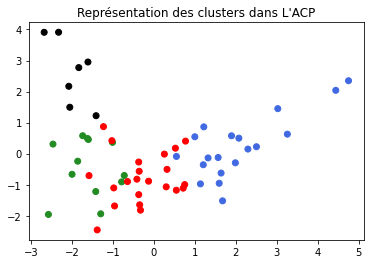

{'Cluster0': ['BGR', 'CHE', 'COL', 'DNK', 'GBR', 'ROU', 'SWE', 'black'], 'Cluster1': ['ARG', 'AUS', 'BOL', 'BRA', 'CRI', 'ECU', 'FIN', 'FRA', 'GAB', 'GTM', 'IDN', 'ITA', 'KEN', 'MEX', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'TGO', 'URY', 'VEN', 'red'], 'Cluster2': ['AUT', 'BGD', 'BWA', 'CHL', 'CHN', 'DOM', 'EGY', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'VNM', 'royalblue'], 'Cluster3': ['CIV', 'CMR', 'COG', 'CUB', 'ETH', 'GHA', 'HND', 'HTI', 'PHL', 'PRY', 'SDN', 'ZMB', 'forestgreen']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,0.062794,-0.903797,-0.846413,-0.784633,0.899305,-1.165323,-1.301798,0.357940,-1.506361,-1.664035,0.0
Centroid 1,-0.236748,0.580681,-0.479015,-0.130927,0.034939,-0.076948,-0.143884,-0.580153,0.705851,0.187523,1.0
Centroid 2,0.750428,-0.385027,0.080952,0.855817,-0.125163,0.968453,0.574118,1.023224,0.120401,0.835653,2.0
Centroid 3,-0.790770,0.072258,1.243762,-0.657308,-0.390474,-0.712542,0.114149,-0.765289,-0.605985,-0.696222,3.0


In [577]:
A,dic,axis=get_cluster_ACP(4,data_set_4, seed = 2)
print(dic)
A.tail(4)

A quatre clusters, le cluster hétérogène identifié ci-dessus est séparé en deux. d'un côté les pays qui ont une croissance significativement plus faible et ue part de l'industrie qui est vraiment plus dynamique, ainqi qu'une croissance qui dépen très peu de la consommation d'énergie. Il s'agit essentiellement des pays les moins développés de notre base de données. De l'autre côté les pays un peu plus développés, dont la part de l'agriculture est assez robuste dans le temps et dont l'évolution de l'industrie est plus faible. 

Ces derniers résultats n'apparaissent toutefois pas de manière automatique, sans doute en raison d'un problème de taille de notre base, qui est trop petite. 

C'est pourquoi nous allons essayer un autre modèle, avec une approche par le clustering hiérarchique, afin de voir s'il est possible de repérer de manière plus évidente des similitudes etre les modèles de développement des pays.